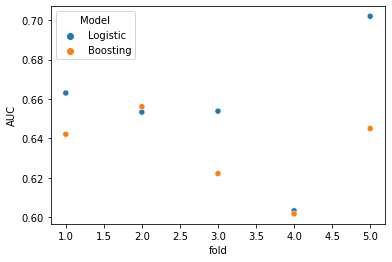

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import t
from tabulate import tabulate

np.random.seed(0)

df = pd.DataFrame({'x1': np.random.normal(0, size=1000), 'x2': np.random.normal(0, size=1000), 'x3': np.random.normal(0, size=1000)})
p = 1 / (1 + np.exp(.1 - .5 * df['x1'] - .3 * df['x2'] + .4 * df['x3']))
df['y'] = np.concatenate(p.apply(lambda x: np.random.binomial(1, x, 1)))

## Parts a and b
# Split data into 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
split = skf.split(df[['x1', 'x2', 'x3']], df['y'])
auc_scores_a, auc_scores_b = [], []

for train_index, test_index in split:
    X_train, y_train = df.loc[train_index, ['x1', 'x2', 'x3']], df.loc[train_index,'y']
    X_test, y_test = df.loc[test_index, ['x1', 'x2', 'x3']], df.loc[test_index, 'y']
    
    logistic_model = LogisticRegression(penalty='none').fit(X_train, y_train)
    boosting_model = GradientBoostingClassifier().fit(X_train, y_train)
    auc_scores_a.append(roc_auc_score(y_test, logistic_model.predict(X_test)))
    auc_scores_b.append(roc_auc_score(y_test, boosting_model.predict(X_test)))

std_dev_a = np.std(auc_scores_a)
std_dev_b = np.std(auc_scores_b)

print(tabulate(
    {'Fold': range(1, 6),
     'Logistic AUC score': auc_scores_a,
     'Boosting AUC score': auc_scores_b},
     headers="keys"), file=open('bstlogit ab 1.txt', 'w'))

print(tabulate(
    {'Model': ['Logistic', 'Boosting'],
     'AUC Standard deviation': [std_dev_a, std_dev_b]},
     headers="keys"), file=open('bstlogit ab 2.txt', 'w'))

# Part c
auc_df = pd.DataFrame({'AUC': auc_scores_a + auc_scores_b,
                       'fold': [n for k in range(0,2) for n in range(1,6)],
                      'Model': ['Logistic' for n in range(5)] + ['Boosting' for n in range(5)]})
sns.scatterplot(data=auc_df, x='fold', y='AUC', hue='Model')
plt.savefig(fname='bstlogit.png')

# Part d
score_difference = [auc_scores_a[i] - auc_scores_b[i] for i in range(5)]
mean = np.mean(score_difference)
sd = np.std(score_difference)
statistic = mean / (sd / 5 ** .5)
t_0 = t.ppf(.975, df=4)